In [3]:
import os # operating system functions, shutil # high-level file operations
import os.path  # for manipulation of file path names
import numpy as np
import pandas as pd
import random
import sklearn.metrics
import time

from matplotlib import pyplot as plt  # for display of images
from random import *

print(os.getcwd())
print(np.__version__)

C:\Users\JayZ2\OneDrive\Desktop\UW -Mitac - Game Algorithm
1.18.1


# INPUT and PARAMETER SETUP

#### Interactive Input Parameters

In [1]:
# Interactive User Input Parameters
total_population = int(float(input('Enter total population size(integer): ')))
relationship_base = int(float(input('Enter relationship base(integer): ')))
mort_worsening=float(input('Enter mortality worsening rate(per day?): ')) # per day rate?
mort_normalising = float(input('Enter mortality normalizing rate(per day?): ')) # what is mortality normalizing rate
target_population = int(float(input('Enter target population size (subset of total population): ')))
transmission_rate =float(input('Enter transmission rate (the % on contact): '))
transmission_decay_rate = float(input('Enter transmission decay rate per day (transmission rate decline occurs when x% of the population are infected): '))
contamination_days=int(float(input('Enter # days an infected person is contigous: ')))
close_contact_daily=int(float(input('Enter # close contact per infected person per day: ')))
trigger=float(input('Enter trigger as % of target populationate: '))
trigger_day=int(float(input('Enter trigger day (eg. 1, start day?): ')))
simulation_period=int(float(input('Enter simulation period in # of days: ')))
simulation_trial=int(float(input('Enter # trial to similate: ')))

# input for markov chain
# 1 = worsening : 2 = stabilising : 3 = normalising
MC_1_1 = float(input('Enter MC_1_1: '))
MC_1_2 = float(input('Enter MC_1_2: '))
MC_1_3 = float(input('Enter MC_1_3: '))

MC_2_1 = float(input('Enter MC_2_1: '))
MC_2_2 = float(input('Enter MC_2_2: '))
MC_2_3 = float(input('Enter MC_2_3: '))

MC_3_1 = float(input('Enter MC_3_1: '))
MC_3_2 = float(input('Enter MC_3_2: '))
MC_3_3 = float(input('Enter MC_3_3: '))

Enter total population size(integer): 5000
Enter relationship base(integer): 90
Enter mortality worsening rate(per day?): 0.001
Enter mortality normalizing rate(per day?): -0.001
Enter target population size (subset of total population): 3700
Enter transmission rate (the % on contact): 0.036
Enter transmission decay rate per day (transmission rate decline occurs when x% of the population are infected): 0
Enter # days an infected person is contigous: 5
Enter # close contact per infected person per day: 10
Enter trigger as % of target populationate: 1
Enter trigger day (eg. 1, start day?): 1
Enter simulation period in # of days: 45
Enter # trial to similate: 10
Enter MC_1_1: 0.75
Enter MC_1_2: 0
Enter MC_1_3: 0.25
Enter MC_2_1: 0
Enter MC_2_2: 0
Enter MC_2_3: 0
Enter MC_3_1: 0
Enter MC_3_2: 0
Enter MC_3_3: 1


In [4]:
# create markov process -- Q1: this seems to be on mortality states only
InfectedStateMarkovProcess =np.array([[MC_1_1,MC_1_2,MC_1_3],[MC_2_1,MC_2_2,MC_2_3],[MC_3_1,MC_3_2,MC_3_3]])
print(InfectedStateMarkovProcess)
print(InfectedStateMarkovProcess[2,2])  # note that index of MarkovProcess is [0,0] to [2,2]

[[0.75 0.   0.25]
 [0.   0.   0.  ]
 [0.   0.   1.  ]]
1.0


In [5]:
# print all Input Parameters
print('------------------------------------------','\nSummary of User Input Parameters:',
          '\n------------------------------------------')
print ("total_population = ",total_population)
print ("relationship_base = ",relationship_base)
print ("mort_worsening= ",mort_worsening)
print ("mort_normalising= ",mort_normalising)
print ("target_population= ",target_population)
print ("transmission_rate= ",transmission_rate)
print ("transmission_decay_rate= ",transmission_decay_rate)
print ("contamination_days= ",contamination_days)
print ("close_contact_daily= ",close_contact_daily)
print ("trigger % of target populaiton = ",trigger)
print ("trigger_day= ",trigger_day)
print ("simulation_period",simulation_period)  # simulation days
print ("simulation_trial",simulation_trial)
print ("InfectedStateMarkovProcess\n",InfectedStateMarkovProcess)


------------------------------------------ 
Summary of User Input Parameters: 
------------------------------------------
total_population =  5000
relationship_base =  90
mort_worsening=  0.001
mort_normalising=  -0.001
target_population=  3700
transmission_rate=  0.036
transmission_decay_rate=  0.0
contamination_days=  5
close_contact_daily=  10
trigger % of target populaiton =  1.0
trigger_day=  1
simulation_period 45
simulation_trial 10
InfectedStateMarkovProcess
 [[0.75 0.   0.25]
 [0.   0.   0.  ]
 [0.   0.   1.  ]]


In [6]:
# Declare Variables
Population_Square = int(1+total_population**(1/2))   # Q2: do we use this anywhere?  what's this for?
Prob_closeness = relationship_base/target_population  # use target_population
print('Population_Square',Population_Square)
print('Prob_closeness',Prob_closeness)

# Q3: some variable not used in VBA:
#Dim TransmissionRateDecreaseSteps As Double # what is this?


Population_Square 71
Prob_closeness 0.024324324324324326


In [7]:
# Declare network matrix
Network=np.zeros((target_population, target_population)) # the matrix of close contacts
print('network shape:\n',Network.shape)
print('network:\n',Network)

network shape:
 (3700, 3700)
network:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# Declare additional variables
InfectedFlag=np.empty((target_population),dtype=bool)          #' infected-flag
#print('InfectedFlag:\n', (InfectedFlag))
InfectedDay = np.zeros((target_population))         #' Start-Day-infected
InfectedEnd=np.zeros((target_population))           # ' End-Day contagion
InfectedState=np.zeros((target_population))         # ' Mortality-State
InfectedMortRate=np.zeros((target_population))      # ' Mortality Rate
InfectedAliveFlag=np.empty((target_population),dtype=bool)     #' Alive-Flag

InfectedNetwork=np.zeros((target_population,200))   #  array of IDs of potential persons to infect--Q4: WHY setup 200 columns to infect? 
InfectedNetCount=np.zeros((target_population))      # number of close contacts - Q5: store the counts of the ID based on Network?
InfectedMadeContact=np.zeros((target_population))   # 'contacted so far since infection Q6: store counts or ID of contacted?
InfectedList=np.zeros((target_population))          #' array of IDs of the infected: [0]=first infected, [1]=2nd infected
InfectedDayOfDeath=np.zeros((target_population))    #' array to record day of death

print('InfectedFlag:\n',InfectedNetwork)
InfectedNetwork[Draw, :].shape

InfectedFlag:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


NameError: name 'Draw' is not defined

In [9]:
Infected=np.zeros((simulation_period)) # array to store daily infected per simulation trial
Death=np.zeros((simulation_period))   # array to store daily death per simulation trial
total_Infected=pd.DataFrame(np.zeros((simulation_period,simulation_trial)),columns=range(simulation_trial)) #setup to store all simu trial
total_Death=pd.DataFrame(np.zeros((simulation_period,simulation_trial)),columns=range(simulation_trial)) #setup to store all simu trial

print('total_Infected setup\n',total_Infected)

total_Infected setup
       0    1    2    3    4    5    6    7    8    9
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
17  0.0  0.0  0.0  0.0  

## Calculation

In [308]:
#seed(1234)
#print(randint(1, 10))
#print(randint(1, 10))
#print(randint(1, 10))

In [10]:
# test on target_population = 3
#Rnd_VBA_1=[[0.8042414,0.2998425,9.276325E-02],[0.3123286,0.5461497,0.1046351],[0.8368326 ,0.8547788,0.8448245]]
#[[0.2554483,0.6550228,0.7133185],[0.9548743 ,0.4183781,0.1508526],[0.5219716 ,0.8904873,0.7768226]]

seed(1234)
Rnd_VBA_1 = np.random.rand(target_population,target_population) # generate a matrix of 
print(type(Rnd_VBA_1))
print(Rnd_VBA_1)
Rnd_VBA_1[0][0]

<class 'numpy.ndarray'>
[[0.33935472 0.80985788 0.6767956  ... 0.10045275 0.44493664 0.98092604]
 [0.56766024 0.70440279 0.49112027 ... 0.51914742 0.848065   0.91340018]
 [0.80061113 0.98930826 0.24901098 ... 0.4460176  0.41245306 0.48669263]
 ...
 [0.05241137 0.52685557 0.88403948 ... 0.47984749 0.90123069 0.03322839]
 [0.65733552 0.69286985 0.57803823 ... 0.88332999 0.59723729 0.16927887]
 [0.92449178 0.39742334 0.4043945  ... 0.56783038 0.35470229 0.60674406]]


0.3393547192221179

In [11]:
seed(1234)
for LoadCounter1 in range(target_population):  
    InfectedFlag[LoadCounter1] = False  #set the initial infected flag for each person in target popl to be FALSE 
    InfectedDay[LoadCounter1] = 0 #set the infected day of each person at zero - Should it be following the net work timeline??
    InfectedEnd[LoadCounter1] = 0 #set End-Day contagion of each person at zeron
    InfectedState[LoadCounter1] = 3     #Inf markov state: ' 1 = worsening : 2 = stabilising : 3 = normalising
    # the above line will make all the people in the target population to have the same Markov State to start with
    InfectedMortRate[LoadCounter1] = 0
    InfectedAliveFlag[LoadCounter1] = True
    for LoadCounter2 in range (target_population):
        Rnd=Rnd_VBA_1[LoadCounter1][LoadCounter2] #uniform(0, 1)
        #print(Rnd)
        #print(Prob_closeness)
        if (Rnd < Prob_closeness):           #' use random draw and the prob_clossness as a guide to assign the relationships
            Network[LoadCounter1, LoadCounter2] = LoadCounter2 + 1 #add one to make sure 1st person is not labled as 0 but 1
        else:
            Network[LoadCounter1, LoadCounter2] = 0
        
print(Network)  
print(InfectedFlag)
print(InfectedAliveFlag)
##### CHECK PASSED ######

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[False False False ... False False False]
[ True  True  True ...  True  True  True]


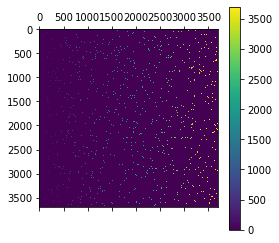

In [12]:
# Plot Network
plt.matshow(Network)  #plt.imshow(Network);
plt.colorbar()
plt.show()

In [13]:
# Define function
def IsThisNewInfected(InfectedList,Draw,TotalInfected):
    #if TotalInfected >= 0:
        #for counter in range (TotalInfected):
            #print("draw:",Draw)
            #print('InfectedList',InfectedList)
            #res=Draw in InfectedList
    return Draw not in InfectedList

In [14]:
#### TESTING BLOCK, not part of main calculation #########
# initiate starting value for total infected and total death
TotalInfected = 3
TotalDeaths = 0
InfectedList2=[1., 2., 3., 0., 0.] # ID of infected persons
Rnd=uniform(0, 1)
Draw = 1
#Draw = int(1 + Rnd * (target_population)) # ID of a person
#IsThisNewInfected(InfectedList2[1],Draw,TotalInfected)
if TotalInfected > 0:
    #for counter in range (TotalInfected):
    print("draw:",Draw)
    print('InfectedList',InfectedList2)
    print(Draw in InfectedList2)

IsThisNewInfected(InfectedList2,Draw,TotalInfected)   # return same out put - Check Passed
#### TESTING BLOCK, not part of main calculation #########

draw: 1
InfectedList [1.0, 2.0, 3.0, 0.0, 0.0]
True


False

In [15]:
# TESTIN _ NOT PART OF MAIN
for LoadCounter1 in range(target_population):  
    InfectedFlag[LoadCounter1] = False
    

print(InfectedFlag[0])
print(InfectedFlag[2]) 
print(InfectedFlag[1])   

False
False
False


In [16]:
start_time=time.time()
for trial in range(simulation_trial):
    print('trial #',trial)
    for LoadCounter1 in range(target_population):  
        InfectedFlag[LoadCounter1] = 'False'  #set the initial infected flag for each person in target popl to be FALSE 
        InfectedDay[LoadCounter1] = 0 #set the infected day of each person at zero - Should it be following the net work timeline??
        InfectedEnd[LoadCounter1] = 0 #set End-Day contagion of each person at zeron
        InfectedState[LoadCounter1] = 3     #Inf markov state: ' 1 = worsening : 2 = stabilising : 3 = normalising
        InfectedMortRate[LoadCounter1] = 0
        InfectedAliveFlag[LoadCounter1] = True
        InfectedList[LoadCounter1] = 0     # isn't this array store the ID
        #'SETUP DAY TIMELINE LOOP
    print('InfectedFlag',InfectedFlag)            
    print('InfectedAliveFlag',InfectedAliveFlag)
    print ('*************************')
    # initiate starting value for total infected and total death
    TotalInfected = 0
    TotalDeaths = 0
    for DayCounter in range(simulation_period):
        #' STEP ONE: pick one person infected from source
        #' get a random number in from uniform(0,1)
        print(f"we are at day {DayCounter}")
        Rnd=0.5  #uniform(0, 1)
        Draw = int(1 + Rnd * (target_population))
        print('Draw=',Draw)
        if (TotalInfected <= (target_population * trigger)) and (DayCounter <= trigger_day): # CHECK person ID = Draw is on InfectedList when Total Infected >0
            print('check condition',(TotalInfected <= (target_population * trigger)), (DayCounter <= trigger_day))
            print('TotalInfected=',TotalInfected)
            print ('%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            if (TotalInfected>=0) and (IsThisNewInfected(InfectedList,Draw,TotalInfected)):
                print('isTHisNewInfected?',IsThisNewInfected(InfectedList,Draw,TotalInfected))
                InfectedFlag[Draw] = True
                InfectedDay[Draw] = DayCounter
                InfectedEnd[Draw] = DayCounter + contamination_days - 1
                InfectedState[Draw] = 1     #Q7: why initially infectedState = 3 and now setup for this person to 1 
                InfectedMortRate[Draw] = InfectedMortRate[Draw] + mort_worsening
                InfectedAliveFlag[Draw] = True
                # declare new variable
                Ind=0
                print('network\n',Network)
                for NetCount in range (target_population): # Q8:NetCount is the ID of the next in contact to be infected?
                    if Network[Draw-1, NetCount] > 0:    # shift index in python
                            print('-----------------')
                            print("NetCount Counter",NetCount)
                            print('Network[Draw-1, NetCount]=',Network[Draw-1, NetCount])
                            Ind = Ind + 1                 # counter of number of contacted by infected person on Network
                            print('Ind=', Ind)
                            InfectedNetwork[Draw-1, Ind-1] = NetCount # the ID of Infected in Network?
                            print('InfectedNetwork[Draw-1, Ind]',InfectedNetwork[Draw-1, Ind-1])
                #next Netcount            
                InfectedNetCount[Draw-1] = Ind        #the number of close contacts by infected Person ID=Draw
                InfectedMadeContact[Draw-1] = 0       #contacted so far since infection? # Q9: what is InfectedMadeContact and why reset to 0?
                TotalInfected = TotalInfected + 1
                InfectedList[TotalInfected-1] = Draw   #index shift by 1 in python
                print('++++++++++++++++++++++++++++++++')
                print(f"for trial {trial}",f"for daycounter {DayCounter}",f"Current infected ID {Draw}")
                print('InfectedNetCount',InfectedNetCount)
                print('InfectedMadeContact',InfectedMadeContact)
                print('TotalInfected',TotalInfected)
                print('InfectedList',InfectedList)
                print('TotalInfected',TotalInfected)
                print('++++++++++++++++++++++++++++++++')
                                    
        # STEP TWO: now loop through the network #'go through the network of all the infected
        for MainLoop in range(TotalInfected):
            print('----------------------------------')
            print('InfectedList = ',InfectedList)
            print(f"at day{DayCounter} our InfectedId on InfectedList[mainLoop] {MainLoop} is {InfectedList[MainLoop]} with {type(InfectedList[MainLoop])}")
            thisperson = int(InfectedList[MainLoop])
            print("thisperson = ",thisperson)
            print('thisperson is the ID of currently infected person which is',thisperson)
            print('InfectedAliveFlag is',InfectedAliveFlag[(thisperson-1)])
            
            if InfectedAliveFlag[int(thisperson-1)]: #' only process if the person is alive #index shift by 1 in python
                #' STEP THREE: now decide on who to infect next            
                for InfectLoop in range(close_contact_daily):
                    
                    if InfectedMadeContact[(thisperson-1)] < 100: # Q10: why 100? And above line had this var reset to 0, would always<0 why?
                        InfectedMadeContact[(thisperson-1)] = InfectedMadeContact[(thisperson-1)] + 1
                        print('++++++++++++++++++++++++++++++++++++')
                        print('thisperson-1 is index',(thisperson-1),'this is the index of row')
                        #print(InfectedMadeContact[(thisperson-1)])
                        #print(int(InfectedMadeContact[(thisperson-1)]))
                        print('index of column to get ID of nexttocontact',int(InfectedMadeContact[(thisperson-1)])-1)
                        print('InfectedNetwork',InfectedNetwork)                                            
                        nexttocontact = int(InfectedNetwork[(thisperson-1), int(InfectedMadeContact[(thisperson-1)])-1])                        
                        print('ID of the nexttocontact is',nexttocontact)
                        print('----------------------------------')                        
                        
                        if nexttocontact > 0: # nexttocontact is the ID of the next to infect
                            if (TotalInfected>=0) and (IsThisNewInfected(InfectedList,nexttocontact,TotalInfected)): #' check if already infected
                                U0_1Draw = uniform(0, 1)
                                if (DayCounter <= InfectedEnd[thisperson-1]) and (U0_1Draw <transmission_rate):
                                    InfectedFlag[nexttocontact] = True
                                    InfectedDay[nexttocontact] = DayCounter
                                    InfectedEnd[nexttocontact] = DayCounter + contamination_days - 1
                                    InfectedState[nexttocontact] = 1   #Q11: why set infected state to 1?
                                    InfectedMortRate[nexttocontact] = InfectedMortRate[nexttocontact] + mort_worsening
                                    InfectedAliveFlag[nexttocontact] = True                                    
                                    print('for this nexttocontact person ID',nexttocontact)
                                    print('InfectedFlag',InfectedFlag)
                                    print('InfectedDay',InfectedDay)
                                    print('InfectedEnd',InfectedEnd)
                                    print('InfectedState',InfectedState)
                                    print('InfectedMortRate',InfectedMortRate)
                                    print('InfectedAliveFlag',InfectedAliveFlag)
                                    Indx = 0
                                    for ContactCount in range (target_population):  # looping through ID
                                        if Network[nexttocontact, ContactCount] > 0:
                                            print('nexttocontact is',nexttocontact,'ContactCount is', ContactCount)
                                            Indx = Indx + 1
                                            InfectedNetwork[nexttocontact, Indx-1] = ContactCount #store the ID
                                    
                                    InfectedNetCount[nexttocontact] = Indx-1
                                    InfectedMadeContact[nexttocontact] = 0
                                    TotalInfected = TotalInfected + 1
                                    InfectedList[TotalInfected-1] = nexttocontact
                                    print('+++++++++++++++++++++')
                                    print('InfectedNetCount',InfectedNetCount)
                                    print('TotalInfected',TotalInfected)
                                    print('InfectedList',InfectedList)
                                    print('TotalInfected',TotalInfected)
                # next InfectedLoop   
                
                #' STEP FOUR: now decide on death
                U0_1Draw = uniform(0, 1)
                print('-------------------')
                print('thisperson',thisperson,'for the day of ',DayCounter)
                if (DayCounter > InfectedEnd[thisperson-1]):
                    if U0_1Draw < InfectedMortRate[thisperson-1]: #'if the random number is less than rate then death
                        InfectedAliveFlag[thisperson-1] = False
                        InfectedDayOfDeath[thisperson-1] = DayCounter
                        TotalDeaths = TotalDeaths + 1
                    else:                        
                        StateChange = uniform(0,1)  #Q12: why there is state change random variable?
                        
                        if (InfectedState[thisperson-1] ==1):
                            if StateChange <= InfectedStateMarkovProcess[0, 0]: # WHY use MC_1_1
                                InfectedState[thisperson-1] = 1
                            else:
                                if StateChange <= (InfectedStateMarkovProcess[0, 0] + InfectedStateMarkovProcess[0,1]):
                                    InfectedState[thisperson-1] = 2
                                else:
                                    InfectedState[thisperson-1] = 3
                        else:   
                            if (InfectedState[thisperson-1] == 2):
                                if StateChange <= InfectedStateMarkovProcess[1, 1]:
                                    InfectedState[thisperson-1] = 2
                                else:
                                    if StateChange <= (InfectedStateMarkovProcess[1, 1] + InfectedStateMarkovProcess[1, 0]):
                                        InfectedState[thisperson-1] = 1
                                    else:
                                        InfectedState[thisperson-1] = 3
                                    #End If
                                #End If
                            else: #' otherwise thisperson is normalising
                                if StateChange <= InfectedStateMarkovProcess[2, 2]:
                                    InfectedState[thisperson-1] = 3
                                else:
                           
                                    if StateChange <= (InfectedStateMarkovProcess[2, 2] + InfectedStateMarkovProcess[2, 0]):
                                        InfectedState[thisperson-1] = 1
                                    else:
                                        InfectedState[thisperson-1] = 2
                                    #End If
                #' reset mortality rate   
                if (InfectedState[thisperson-1] ==1):
                    if ((InfectedMortRate[thisperson-1] + mort_worsening) < 1):
                        InfectedMortRate[thisperson-1] = InfectedMortRate[thisperson-1] + mort_worsening
                    else:
                        InfectedMortRate[thisperson-1] = 1
                    #End If
                else:
                    if (InfectedState[thisperson-1] == 3):
                        if (InfectedMortRate[thisperson-1] + mort_normalising > 0):
                            InfectedMortRate[thisperson-1] = InfectedMortRate[thisperson-1] + mort_normalising
                        else:
                            InfectedMortRate[thisperson-1] = 0   # ' for now
                        #End If
                        
           #next mainLoop
        
        total_Infected.iloc[DayCounter,trial]= TotalInfected
        total_Death.iloc[DayCounter,trial]=TotalDeaths
        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
        print('postiion',DayCounter,trial)
        print(DayCounter,'total infect is ',TotalInfected)
        
print("--- %s seconds ---" % (time.time() - start_time))       

trial # 0
InfectedFlag [ True  True  True ...  True  True  True]
InfectedAliveFlag [ True  True  True ...  True  True  True]
*************************
we are at day 0
Draw= 1851
check condition True True
TotalInfected= 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
isTHisNewInfected? True
network
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
-----------------
NetCount Counter 73
Network[Draw-1, NetCount]= 74.0
Ind= 1
InfectedNetwork[Draw-1, Ind] 73.0
-----------------
NetCount Counter 116
Network[Draw-1, NetCount]= 117.0
Ind= 2
InfectedNetwork[Draw-1, Ind] 116.0
-----------------
NetCount Counter 176
Network[Draw-1, NetCount]= 177.0
Ind= 3
InfectedNetwork[Draw-1, Ind] 176.0
-----------------
NetCount Counter 271
Network[Draw-1, NetCount]= 272.0
Ind= 4
InfectedNetwork[Draw-1, Ind] 271.0
-----------------
NetCount Counter 342
Network[Draw-1, NetCount]= 343.0
Ind= 5
InfectedNetwork[Draw-1, Ind] 

 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 115 this is the index of row
index of column to get ID of nexttocontact 34
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 115 this is the index of row
index of column to get ID of nexttocontact 35
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 115 this is the index of row
index of column to get ID of nexttocontact 36
InfectedNetwork [[0. 0. 0. ... 0. 0.

-------------------
thisperson 116 for the day of  14
----------------------------------
InfectedList =  [1851.  116.  611. ...    0.    0.    0.]
at day14 our InfectedId on InfectedList[mainLoop] 2 is 611.0 with <class 'numpy.float64'>
thisperson =  611
thisperson is the ID of currently infected person which is 611
InfectedAliveFlag is True
-------------------
thisperson 611 for the day of  14
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 14 0
14 total infect is  3
we are at day 15
Draw= 1851
----------------------------------
InfectedList =  [1851.  116.  611. ...    0.    0.    0.]
at day15 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  15
----------------------------------
InfectedList =  [1851.  116.  611. ...    0.    0.    0.]
at day15 our InfectedId on InfectedList[mainLoop] 1 

 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 3294
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 67
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 3370
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 68
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 3439
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 69
InfectedNetwork [[0. 0. 

 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 81
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 82
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 83
InfectedNetwork [[0. 0. 0. ... 0.

postiion 8 3
8 total infect is  1
we are at day 9
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day9 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 90
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 91
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 94
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 95
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 96
InfectedNetwork [[0. 0. 0. ... 0.

InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day12 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  12
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 12 5
12 total infect is  1
we are at day 13
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day13 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  13
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 13 5
13 total infect is  1
we are at day 14
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day14 our InfectedId on I

Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day16 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  16
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 16 6
16 total infect is  1
we are at day 17
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day17 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  17
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 17 6
17 total infect is  1
we are at day 18
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...  

26 total infect is  1
we are at day 27
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day27 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  27
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 27 7
27 total infect is  1
we are at day 28
Draw= 1851
----------------------------------
InfectedList =  [1851.    0.    0. ...    0.    0.    0.]
at day28 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  28
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 28 7
28 total infect is  1
we are at day 29
Draw= 1851
----------------------------------
I

thisperson 116 for the day of  19
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 19 8
19 total infect is  2
we are at day 20
Draw= 1851
----------------------------------
InfectedList =  [1851.  116.    0. ...    0.    0.    0.]
at day20 our InfectedId on InfectedList[mainLoop] 0 is 1851.0 with <class 'numpy.float64'>
thisperson =  1851
thisperson is the ID of currently infected person which is 1851
InfectedAliveFlag is True
-------------------
thisperson 1851 for the day of  20
----------------------------------
InfectedList =  [1851.  116.    0. ...    0.    0.    0.]
at day20 our InfectedId on InfectedList[mainLoop] 1 is 116.0 with <class 'numpy.float64'>
thisperson =  116
thisperson is the ID of currently infected person which is 116
InfectedAliveFlag is True
-------------------
thisperson 116 for the day of  20
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 20 8
20 total infect is  2
we are at day 21
Draw= 1851
----------------------------------
InfectedList =  [1851

 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 98
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
++++++++++++++++++++++++++++++++++++
thisperson-1 is index 1850 this is the index of row
index of column to get ID of nexttocontact 99
InfectedNetwork [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
ID of the nexttocontact is 0
----------------------------------
-------------------
thisperson 1851 for the day of  9
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
postiion 9 9
9 total infect is  1
we are at day 10
Draw= 1851
-------

In [17]:
total_Infected

,0,1,2,3,4,5,6,7,8,9
0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
1,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
2,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
3,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
4,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
5,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
6,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
7,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
8,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
9,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0


In [18]:
total_Death

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Coverting VBA code to Python
#http://vb2py.sourceforge.net/online_conversion.html